/Users/mgrecu/miniconda3/lib/python3.9/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,


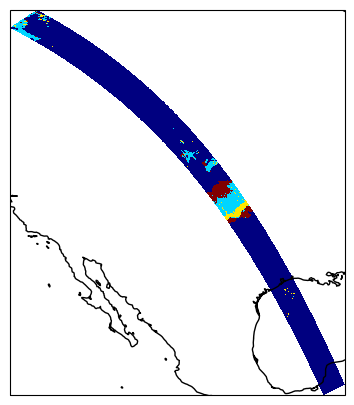

In [41]:
import io_subs
from pyresample import image, geometry
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import importlib
importlib.reload(io_subs)

wf = lambda r: 1 - r/20000.0

#!ls Data/
f='Data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20180625-S050505-E051345.024557.V07A.HDF5'
f='2B.GPM.DPRGMI.CORRA2022OE.20180625-S041042-E054316.024557.ITE790.HDF5'
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,oe_wvp,oe_lwp,oe_iwp,oesfc_precip,stormTop,nearSfcPrecip,zeroDeg=io_subs.readCMB(f)
f1='Data/1C.GPM.GMI.XCAL2016-C.20180625-S041042-E054316.024557.V07A.HDF5'
lat_s1,lon_s1,tb_s1=io_subs.read1CGMI(f1)

# Define the input and output grids
input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling

tb_s1_resampled = resample_custom(input_def, tb_s1[:,:,:], output_def, radius_of_influence=30000, neighbours=10, 
weight_funcs=[wf for k in range(9)], fill_value=None)
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
pTypem=np.ma.array(pType,mask=skTemp<273.15)
ax.coastlines()
n1,n2=4500,5500
plt.pcolormesh(lon[n1:n2,:],lat[n1:n2,:],pTypem[n1:n2,:]/1e7,cmap='jet')


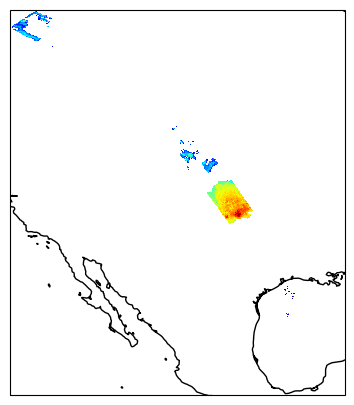

In [2]:

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon[n1:n2,:],lat[n1:n2,:],stormTop[n1:n2,:,0],cmap='jet')

In [43]:
x_inp=[]
nt,nr=lon.shape
import pickle
# read scaler from tbobs_60_120.scaler.pkl
scaler=pickle.load(open('tbobs_0_60.scaler_2.pkl','rb'))
x_sfcBinL=[]
x_owvpL=[]
x_skTempL=[]
x_zeroDegL=[]
for i in range(4,nt-5):
    for j in range(3,nr-4):
        x_inp.append(tb_s1_resampled[i-3:i+4,j-3:j+4,:])
        x_skTempL.append((skTemp[i-3:i+4,j-3:j+4]-273.15)/5)
        x_zeroDegL.append(zeroDeg[i-3:i+4,j-3:j+4]/2e3)
        x_sfcBinL.append((88-sfcBin[i-3:i+4,j-3:j+4,0:1])/30)
        x_owvpL.append((oe_wvp[i-3:i+4,j-3:j+4,np.newaxis]-22)/15.)

In [44]:
#print(x_inp.shape)
x_inp=np.array(x_inp)
x_sfcBinL=np.array(x_sfcBinL)
x_owvpL=np.array(x_owvpL)
x_skTempL=np.array(x_skTempL)
x_zeroDegL=np.array(x_zeroDegL)
print(x_inp.shape,x_sfcBinL.shape)

for i in range(9):
    x_inp[:,:,:,i]=(x_inp[:,:,:,i]-scaler.mean_[i])/scaler.scale_[i]
    


(332892, 7, 7, 9) (332892, 7, 7, 1)


In [45]:
x_forward=np.concatenate((x_inp,x_skTempL[:,:,:,np.newaxis],x_zeroDegL[:,:,:,np.newaxis],x_sfcBinL,x_owvpL),axis=3)
n1r=nt-9
n2r=nr-7
# read tensorflow from forward_model_60to120_rain_4iters.h5 
from tensorflow import keras
#discr_model=keras.models.load_model('forward_model_gmi_60to120_rain_4iters.h5')
#iprecip=discr_model.predict(x_forward).reshape(n1,n2)
#print(x_inp.shape,n1*n2)

In [46]:
print(x_inp.shape,x_skTempL.shape,x_sfcBinL.shape,x_owvpL.shape)

(332892, 7, 7, 9) (332892, 7, 7) (332892, 7, 7, 1) (332892, 7, 7, 1)


In [51]:
#load model from ("forward_model_60to120_noover_10iters.h5")

geophysics_model=keras.models.load_model("forward_model_regr_obsTb_0_120.h5")
geoParams=geophysics_model.predict(x_forward)
n1r=nt-9
n2r=nr-7
stormTop_nn=geoParams[:,-2].reshape(n1r,n2r)


10403/10403 [==============================] - 6s 570us/step


(7935, 49, 2)
4500 5500
(1000, 42)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_53651/2742007675.py:2: RuntimeWarning: overflow encountered in power
  rwp=(10**rwp-1)*10
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_53651/2742007675.py:2: RuntimeWarning: overflow encountered in multiply
  rwp=(10**rwp-1)*10


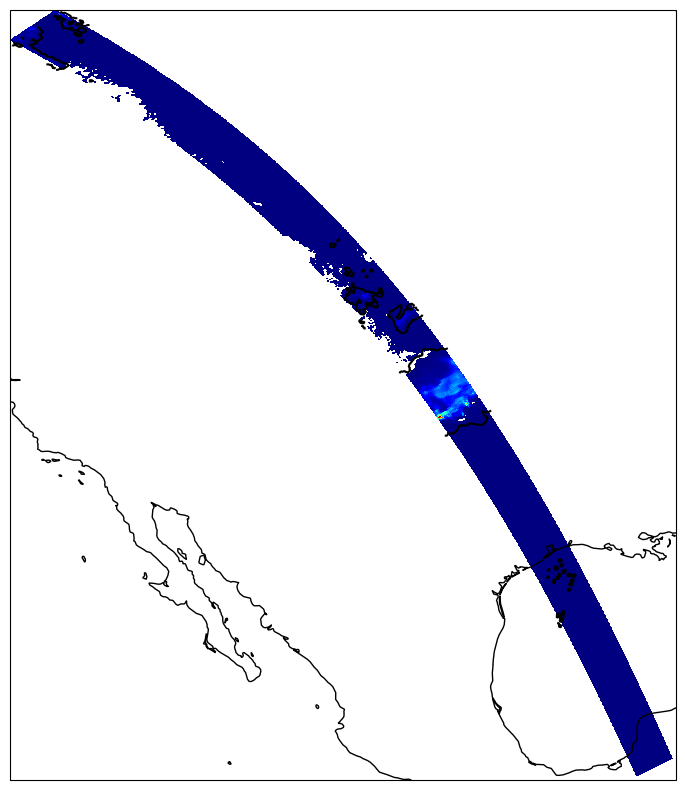

In [59]:
rwp=geoParams[:,-1].reshape(n1r,n2r)
rwp=(10**rwp-1)*10
print(stormTop.shape)
n1,n2=4500,5500
fig=plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
lon_sub=lon[n1:n2,:]
lat_sub=lat[n1:n2,:]
print(n1,n2)
stormTop_sub=stormTop_nn[n1:n2,:]
rainwp_sub=rwp[n1:n2,:]
rainwp_subm=np.ma.array(rainwp_sub,mask=rainwp_sub<0.1)
print(stormTop_sub.shape)
ax.coastlines()
c=plt.pcolormesh(lon_sub[:,3:nr-4],lat_sub[:,3:nr-4],rainwp_subm,cmap='jet')
#c=plt.pcolormesh(lon_sub[:,3:nr-4],lat_sub[:,3:nr-4],stormTop_sub,cmap='jet')
plt.contour(lon[n1+3:n2+3,:],lat[n1+3:n2+3,:],pType[n1+3:n2+3,:],levels=[1.0],colors='black')


In [ ]:

fig=plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
lon_sub=lon[n1:n2,:]
lat_sub=lat[n1:n2,:]
print(n1,n2)
stormTop_sub=stormTop_nn[n1:n2,:]
rainwp_sub=rwp[n1:n2,:]
print(stormTop_sub.shape)
ax.coastlines()
rwp=(np.exp(rainwp_sub[:,:])-1)*10.
print(rwp.shape)
emiss=geoParams[:,0].reshape(n1r,n2r)
rwpm=np.ma.array(emiss[n1:n2,:],mask=rwp<.01)
c=plt.pcolormesh(lon_sub[:,3:nr-4],lat_sub[:,3:nr-4],rwpm,cmap='jet',vmin=0.1,vmax=1.0)
plt.contour(lon[n1+3:n2+3,:],lat[n1+3:n2+3,:],pType[n1+3:n2+3,:],levels=[1.0],colors='black')
plt.colorbar(c,shrink=0.75)   
plt.savefig('rwp_nn_simTB_DB.png')

[[1.         0.74748861]
 [0.74748861 1.        ]]


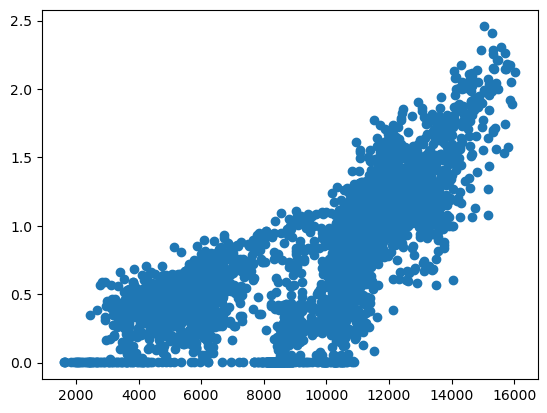

In [54]:
a=np.nonzero(stormTop[n1+3:n2+3,3:nr-4,-1]>0)
print(np.corrcoef(stormTop[n1+3:n2+3,3:nr-4,-1][a],stormTop_sub[a]))
plt.scatter(stormTop[n1+3:n2+3,3:nr-4,-1][a],stormTop_sub[a])

0.7966438507396776
0 3797


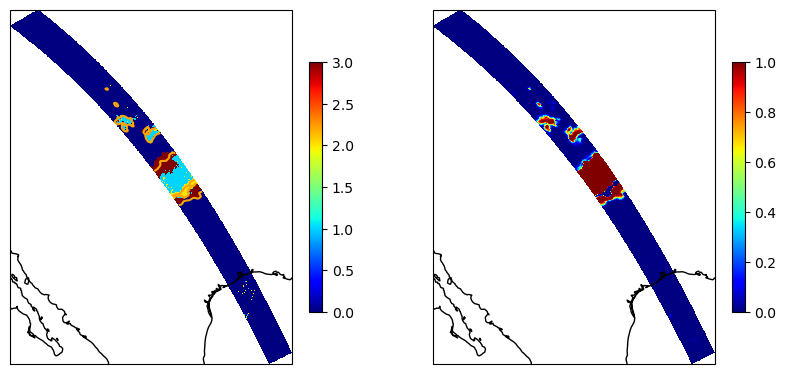

In [75]:
fig=plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
c1=plt.pcolormesh(lon[4:nt-5,3:nr-4],lat[4:nt-5,3:nr-4],pType[4:nt-5,3:nr-4]/1e7,cmap='jet')
plt.contour(lon[4:nt-5,3:nr-4],lat[4:nt-5,3:nr-4],iprecip,levels=[0.5],colors='orange')
plt.colorbar(c1,shrink=0.65)
ax.coastlines()

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
iprecipm=np.ma.array(iprecip,mask=iprecip<0.9)
plt.pcolormesh(lon[4:nt-5,3:nr-4],lat[4:nt-5,3:nr-4],iprecip,cmap='jet')
ax.coastlines()
plt.colorbar(shrink=0.65)    

a=np.nonzero(pType[4:nt-5,3:nr-4]>0)
b=np.nonzero(iprecip[a]>0.5)
print(len(b[0])/len(a[0]))

a=np.nonzero(iprecip>0.5)
b=np.nonzero(pType[a]==0)
print(len(b[0]),len(a[0]))